# Yield models used in R68 analysis

Nick Mast, 27 March 2020

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exec(open("nb_setup.py").read())
import R68_yield as Yield
import R68_plot_tools as pt

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


## Common Models
In the R68 analysis, we consider several different yield model paramterizations. The first is Lindhard (http://gymarkiv.sdu.dk/MFM/kdvs/mfm%2030-39/mfm-33-10.pdf).
\begin{equation}
y_L(E_r,k) = \frac{kg}{1+kg}
\end{equation}
where $g = 3 \varepsilon^{0.15} + 0.7\varepsilon^{0.6} + \varepsilon$ and $\varepsilon = 11.5 E_r [keV] Z^{-7/3}$ and here, Z=14 (Si). This Lindhard model has been used successfully for a variety of materials, however it is expected to be incorrect at low energies.

There are few models which add low-energy cutoffs to Lindhard in various ways. One, from Chavarria (https://arxiv.org/pdf/1803.02903.pdf), is an empirical behavior to match Damic measurements. $a^{-1}$ sets the scale at which the cutoff begins. This function falls faster than Lindhard, but still goes to Y(0)=0.

\begin{equation}
y_C(E_r,k,a) = \left(\frac{1}{a E_r}+\frac{1}{y_L(E_r,k)}\right)^{-1}
\end{equation}

A model from Sorensen(https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.083509) by a low-energy ionization threshold such as in semiconductors. This manifests in a cutoff scale set by a parameter $q$, in the same units as Lindhard's $\varepsilon$. This function has a cutoff energy below which Y=0.

\begin{equation}
y_S(E_r,k,q) = y_L(E_r,k)-\frac{q}{\varepsilon}
\end{equation}

Another low energy modification used by Scholz (https://journals.aps.org/prd/pdf/10.1103/PhysRevD.94.122003) introduces an "adiabatic correction factor" to supress yield at some scale $\xi$.

\begin{equation}
y_{AC}(E_r,k,\xi)=(1-exp[-E_r/\xi])\times y_L(E_r,k)
\end{equation}

In [3]:
E_thresh=50 #[eV] Analysis threshold
E_test=np.logspace(-1,4,1000)

eVTOeps = 11.5*1/1000*14**(-7./3)

fig_w=7

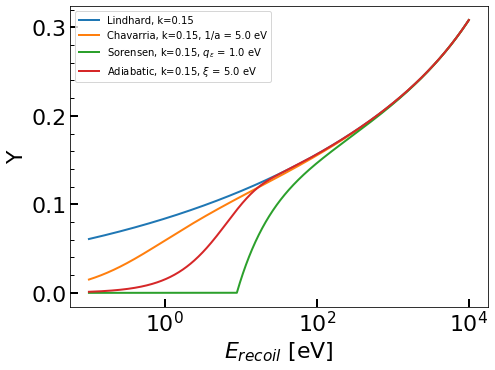

In [8]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

k=0.15

Y=Yield.Yield('Lind',[k])
plt.plot(E_test,Y.calc(E_test),label='Lindhard, k={0:.2f}'.format(k))

ainv=5 #[eV]
Y=Yield.Yield('Chav',[0.15,ainv])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k={0:.2f}, 1/a = {1:.1f} eV'.format(k,ainv))

qeff_eV=1 #[eV]
Y=Yield.Yield('Sor',[0.15,qeff_eV*eVTOeps])
plt.plot(E_test,Y.calc(E_test),label='Sorensen, k={0:.2f}, $q_\epsilon$ = {1:.1f} eV'.format(k,qeff_eV))

xi=5 #[eV]
Y=Yield.Yield('AC',[0.15,xi])
plt.plot(E_test,Y.calc(E_test),label=r'Adiabatic, k={0:.2f}, $\xi$ = {1:.1f} eV'.format(k,xi))

ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Y')
ax.set_xscale('log')

plt.legend()
plt.tight_layout()
plt.savefig('figures/yield_models.png')

# Shelf-Exponential Yield Cutoff Model

All of the above models start with the Lindhard yield curve and supress it at low energies. While the presence of some cutoff is well-motivated, there is no reason to assume that Lindhard is an upper bound at low energies. To allow more freedom in the low energy yield shape, a more flexible model was developed. This model allows for the yield to plateau, or have a shelf, before an exponential cutoff, thus we give it the very un-sexy name of the "Shexp" model. This model allows for the yield to exceed that of Lindhard, as well as cut off, all while remaining monatonic. The function is defined as

\begin{equation}
  y_{Shexp}(E_r,k,Y_{shelf},\alpha,E_c,dE) = (1-exp[-(Er-Ec)/dE])\times(y_L(E_r,k)^\alpha+Y_{shelf}^\alpha)^{1/\alpha}
\end{equation}

where $Y_{shelf}$ is the value of the flat yield shelf, $\alpha$ is a smoothing parameter between the shelf and Lindhard, $Ec$ is the cutoff scale below which Y=0, and $dE$ is the width of the cutoff transition. The effect of these parameters is illustrated in the figure below.

In [7]:
#k: Lindhard k
#Yshelf: Value of flat yield shelf
#Ec: cutoff energy at which Y->0 [eV]
#dE: width of cutoff transition [eV]
#alpha: smoothing parameter between shelf and lindhard
def yLind_shelf_exp(Er,k,Yshelf,Ec,dE,alpha):
    yL=Yield.yLind(Er, k)

    return (Er>Ec)*(1-np.exp(-(Er-Ec)/dE))*np.power(np.power(yL,alpha)+np.power(Yshelf,alpha),1/alpha)

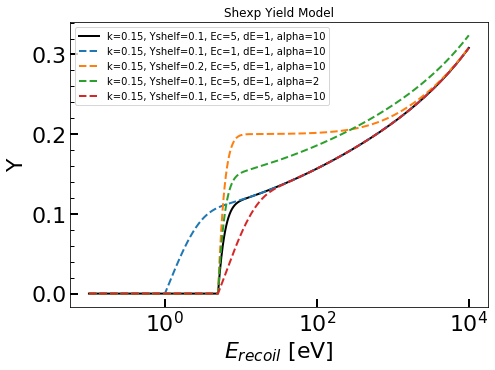

In [29]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

text='k={0:.2f}, Yshelf={1:.1f}, Ec={2:.0f}, dE={3:.0f}, alpha={4:.0f}'
Shexp_pars=[0.15,0.1,5,1,10]
plt.plot(E_test,yLind_shelf_exp(E_test,*Shexp_pars),'-k',label=text.format(*Shexp_pars))

Shexp_pars=[0.15,0.1,1,1,10]
plt.plot(E_test,yLind_shelf_exp(E_test,*Shexp_pars),'--',label=text.format(*Shexp_pars))

Shexp_pars=[0.15,0.2,5,1,10]
plt.plot(E_test,yLind_shelf_exp(E_test,*Shexp_pars),'--',label=text.format(*Shexp_pars))

Shexp_pars=[0.15,0.1,5,1,2]
plt.plot(E_test,yLind_shelf_exp(E_test,*Shexp_pars),'--',label=text.format(*Shexp_pars))

Shexp_pars=[0.15,0.1,5,5,10]
plt.plot(E_test,yLind_shelf_exp(E_test,*Shexp_pars),'--',label=text.format(*Shexp_pars))

ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Y')
ax.set_xscale('log')
ax.set_title('Shexp Yield Model')

plt.legend()
plt.tight_layout()
plt.savefig('figures/Shexp_yield_examples.png')

The extra freedom of this model requires more parameters than other yield models. However, it is also versatile enough to be able to closely generate the same behavior as any of the above models. This is deomonstrated in the figure below, where the Shexp model has been fit to examples of each of the other yield models.

In [31]:
from scipy.optimize import curve_fit
#Try to fit other yield models with Lindhard+exp

bounds=(0,np.inf)
k=0.15
Y=Yield.Yield('Lind',[k])
popt_l,pcov=curve_fit(yLind_shelf_exp,E_test,Y.calc(E_test),p0=[0.15,0.1,5e0,1e1,10],bounds=bounds)
print(popt_l)

ainv=5 #[eV]
Y=Yield.Yield('Chav',[0.15,ainv])
popt_c,pcov=curve_fit(yLind_shelf_exp,E_test,Y.calc(E_test),p0=[0.15,0.1,5e0,1e1,10],bounds=bounds)
print(popt_c)

qeff_eV=1 #[eV]
Y=Yield.Yield('Sor',[0.15,qeff_eV*eVTOeps])
popt_s,pcov=curve_fit(yLind_shelf_exp,E_test,Y.calc(E_test),p0=[0.15,0.1,5e0,1e1,10],bounds=bounds)
print(popt_s)

xi=5 #[eV]
Y=Yield.Yield('AC',[0.15,xi])
popt_a,pcov=curve_fit(yLind_shelf_exp,E_test,Y.calc(E_test),p0=[0.15,0.1,5e0,1e1,10],bounds=bounds)
print(popt_a)

[1.50000000e-01 6.03212893e-02 7.19097591e-02 4.02331202e-03
 1.90426485e+02]
[1.47982784e-01 8.97364619e-02 6.16913025e-09 8.58333147e-01
 7.46800553e+01]
[ 0.14750023  0.0336585   7.05001645 15.78174277 12.66047515]
[1.50000000e-01 3.60490077e-02 6.77461047e-09 5.00000001e+00
 1.95544180e+01]


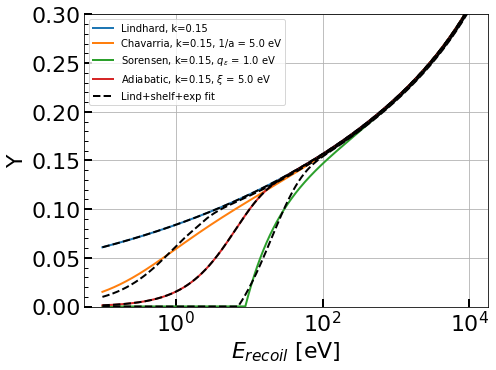

In [32]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

k=0.15

Y=Yield.Yield('Lind',[k])
plt.plot(E_test,Y.calc(E_test),label='Lindhard, k={0:.2f}'.format(k))

ainv=5 #[eV]
Y=Yield.Yield('Chav',[0.15,ainv])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k={0:.2f}, 1/a = {1:.1f} eV'.format(k,ainv))

qeff_eV=1 #[eV]
Y=Yield.Yield('Sor',[0.15,qeff_eV*eVTOeps])
plt.plot(E_test,Y.calc(E_test),label='Sorensen, k={0:.2f}, $q_\epsilon$ = {1:.1f} eV'.format(k,qeff_eV))

xi=5 #[eV]
Y=Yield.Yield('AC',[0.15,xi])
plt.plot(E_test,Y.calc(E_test),label=r'Adiabatic, k={0:.2f}, $\xi$ = {1:.1f} eV'.format(k,xi))


plt.plot(E_test,yLind_shelf_exp(E_test,*popt_l),'k--',label='Lind+shelf+exp fit')
plt.plot(E_test,yLind_shelf_exp(E_test,*popt_c),'k--')
plt.plot(E_test,yLind_shelf_exp(E_test,*popt_s),'k--')
plt.plot(E_test,yLind_shelf_exp(E_test,*popt_a),'k--')

#Y=Yield.Yield('Shexp',[0.15,0.15,1e0,1e0,5])
#plt.plot(E_test,Y.calc(E_test),'-k',label='Lind+shelf+exp arb')


ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Y')
ax.set_xscale('log')
ax.set_ylim(0,0.3)

plt.grid()

plt.legend()
plt.tight_layout()
plt.savefig('figures/yield_models_Shexp_fit.png')